# Предварительная настройка

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchsummary import summary
from sklearn import metrics
import matplotlib.pyplot as plt
import time
import os
import sys
import copy
import random

In [ ]:
def init_random_seed(value=0):
    random.seed(value)
    np.random.seed(value)
    torch.manual_seed(value)
    torch.cuda.manual_seed(value)
    torch.backends.cudnn.deterministic = True

init_random_seed()

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Датасет

**image loaders** https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

**data loaders** https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [ ]:
EPOCHS=20
NAME1='Fires'
NAME2='Humans'
NAME3='Weapons'

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        # transforms.RandomRotation(degrees=(-90, 90)),      
        transforms.Resize(224),
        # transforms.RandomResizedCrop(224),
        transforms.CenterCrop(224),
        # transforms.ColorJitter(brightness=.3),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


data_dir1 = '/content/drive/My Drive/AI/Samsung/'+NAME1
image_datasets1 = {x: datasets.ImageFolder(os.path.join(data_dir1, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders1 = {x: torch.utils.data.DataLoader(image_datasets1[x], batch_size=4,
                                             shuffle=True, num_workers=4, drop_last=True )
                  for x in ['train', 'val']}
dataset_sizes1 = {x: len(image_datasets1[x]) for x in ['train', 'val']}
class_names1 = image_datasets1['train'].classes
###
data_dir2 = '/content/drive/My Drive/AI/Samsung/'+NAME2
image_datasets2 = {x: datasets.ImageFolder(os.path.join(data_dir2, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders2 = {x: torch.utils.data.DataLoader(image_datasets2[x], batch_size=4,
                                             shuffle=True, num_workers=4, drop_last=True)
                  for x in ['train', 'val']}
dataset_sizes2 = {x: len(image_datasets2[x]) for x in ['train', 'val']}
class_names2 = image_datasets2['train'].classes
###
data_dir3 = '/content/drive/My Drive/AI/Samsung/'+NAME3
image_datasets3 = {x: datasets.ImageFolder(os.path.join(data_dir3, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders3 = {x: torch.utils.data.DataLoader(image_datasets3[x], batch_size=4,
                                             shuffle=True, num_workers=4, drop_last=True)
                  for x in ['train', 'val']}
dataset_sizes3 = {x: len(image_datasets3[x]) for x in ['train', 'val']}
class_names3 = image_datasets3['train'].classes

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


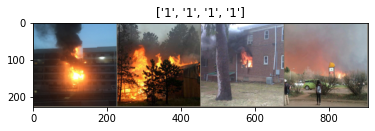

In [ ]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders1['train']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names1[x] for x in classes])

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


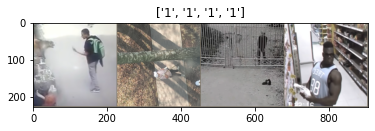

In [ ]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders2['train']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names2[x] for x in classes])

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


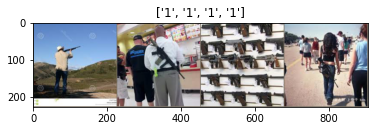

In [ ]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders3['train']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names3[x] for x in classes])

In [ ]:
def train_model(model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch=0; best_acc = 0.0; best_loss = sys.maxsize
    hist_loss_train = []; hist_acc_train = []; 
    hist_loss_val = []; hist_acc_val = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item()* inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.to('cpu').data.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            if phase == 'train':
                hist_loss_train.append(epoch_loss)
                hist_acc_train.append(epoch_acc)
            else:     
                hist_loss_val.append(epoch_loss)
                hist_acc_val.append(epoch_acc)

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_acc = epoch_acc
                best_loss = epoch_loss
                best_epoch = epoch
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
    
    model.eval()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best epoch:{} val Loss:{:4f} Acc: {:4f}'.format(best_epoch,best_loss,best_acc))

    plt.plot(np.arange(0,num_epochs),hist_loss_train,label='hist_loss_train')
    plt.plot(np.arange(0,num_epochs),hist_loss_val,label='hist_loss_val')
    plt.legend(framealpha=1, frameon=True);
    plt.title('Loss')
    plt.show()
    plt.plot(np.arange(0,num_epochs),hist_acc_train,label='hist_acc_train')
    plt.plot(np.arange(0,num_epochs),hist_acc_val,label='hist_acc_val')
    plt.legend(framealpha=1, frameon=True);
    plt.title('Acc')
    plt.show()


    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def visualize_model(model, dataloaders, class_names, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            t0 = time.time()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            print("Время инфренса батча(мс): {:4f}".format((time.time()-t0)*1000))
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# cut model - for first stage

https://medium.com/the-owl/extracting-features-from-an-intermediate-layer-of-a-pretrained-model-in-pytorch-c00589bda32b

In [ ]:
class new_model(nn.Module):
    def __init__(self,model, output_layer = None):
        super().__init__()
        model = copy.deepcopy(model)
        model.eval()
        for param in model.parameters():
            param.requires_grad = False
        self.pretrained = model
        self.output_layer = output_layer
        self.layers = list(self.pretrained._modules.keys())
        self.layer_count = 0
        for l in self.layers:
            # print(l)
            if l != self.output_layer:
                self.layer_count += 1
            else:
                break
        for i in range(1,len(self.layers)-self.layer_count):
            self.dummy_var = self.pretrained._modules.pop(self.layers[-i])

        self.net = nn.Sequential(self.pretrained._modules)
        self.net = nn.Sequential(self.net,nn.AdaptiveAvgPool2d(1),nn.Flatten())
        self.pretrained = None

    def forward(self,x):
        x = self.net(x)
        return x

    def save(self):
        input_tensor = torch.rand(1,3,224,224)
        script_model = torch.jit.trace(self.net.to('cpu'),input_tensor)
        script_model.save("/content/drive/My Drive/AI/Samsung/base.pt")

In [ ]:
model = new_model(models.resnet18(pretrained=True),output_layer = "layer4")
# model = new_model(models.resnet50(pretrained=True),output_layer = "layer4")
summary(model.to(device),input_size=(3, 224, 224))
model.save()
model = model.to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [ ]:
# summary(models.resnet18(pretrained=True).to(device),input_size=(3, 224, 224))

In [ ]:
class new_model_2stage(nn.Module):
  # SIZE=2048
  SIZE=512
  def __init__(self,net,name):
      super().__init__()
      self.net=net
      self.name=name
      self.model=nn.Sequential(nn.Linear(self.SIZE, 64),
                               nn.BatchNorm1d(64), 
                               nn.Dropout1d(0.2), 
                               nn.ReLU(), 
                               nn.Linear(64, 16),
                               nn.BatchNorm1d(16), 
                               nn.Dropout1d(0.2), nn.ReLU(),nn.Linear(16, 2))
  def forward(self,x):
        x = self.net(x)
        x=self.model(x)
        return x   
  def eval(self):
      self.net.eval()
      self.model.eval()
  def train(self,mode=True): 
      self.net.eval()
      self.model.train(mode)
  def print(self):
        summary(self.model,input_size=(1,self.SIZE))
  def save(self):
      print(self.name)
      input_tensor = torch.rand(1,self.SIZE)
      script_model = torch.jit.trace(self.model.to('cpu'),input_tensor)
      script_model.save("/content/drive/My Drive/AI/Samsung/"+self.name+".pt")   


In [ ]:
model_ft = new_model_2stage(model,NAME1)
model_ft = model_ft.to(device)
criterion_ft = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
# optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0005)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler_ft = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
# model_ft.print()

Epoch 0/19
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.6203 Acc: 0.6288
val Loss: 0.4289 Acc: 0.8684

Epoch 1/19
----------
train Loss: 0.5053 Acc: 0.6987
val Loss: 0.4020 Acc: 0.8947

Epoch 2/19
----------
train Loss: 0.4423 Acc: 0.7467
val Loss: 0.3653 Acc: 0.8947

Epoch 3/19
----------
train Loss: 0.4477 Acc: 0.7642
val Loss: 0.3050 Acc: 0.8684

Epoch 4/19
----------
train Loss: 0.4024 Acc: 0.8079
val Loss: 0.2571 Acc: 0.9211

Epoch 5/19
----------
train Loss: 0.4471 Acc: 0.8035
val Loss: 0.2600 Acc: 0.9211

Epoch 6/19
----------
train Loss: 0.4292 Acc: 0.7948
val Loss: 0.2958 Acc: 0.8947

Epoch 7/19
----------
train Loss: 0.3604 Acc: 0.8472
val Loss: 0.2876 Acc: 0.8947

Epoch 8/19
----------
train Loss: 0.3715 Acc: 0.8210
val Loss: 0.2972 Acc: 0.9211

Epoch 9/19
----------
train Loss: 0.4017 Acc: 0.8384
val Loss: 0.2551 Acc: 0.8684

Epoch 10/19
----------
train Loss: 0.4659 Acc: 0.7860
val Loss: 0.2701 Acc: 0.8684

Epoch 11/19
----------
train Loss: 0.4247 Acc: 0.7904
val Loss: 0.2851 Acc: 0.8684

Epoch 12/19
----------
t

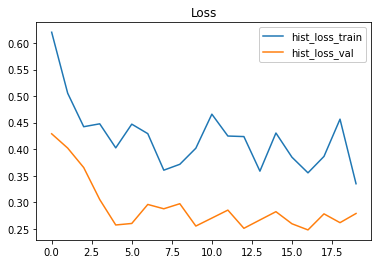

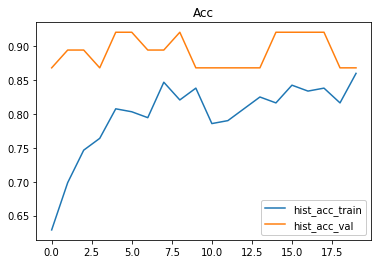

--- 93.66577243804932 seconds ---


In [ ]:
import time
start_time = time.time()
model_ft = train_model(model_ft, criterion_ft, optimizer_ft, exp_lr_scheduler_ft,dataloaders1,dataset_sizes1,
                       num_epochs=EPOCHS)
print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
model_ht = new_model_2stage(model,NAME2)
model_ht = model_ht.to(device)
criterion_ht = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_ht = optim.SGD(model_ht.parameters(), lr=0.001, momentum=0.9)
# optimizer_ht = optim.Adam(model_ht.parameters(), lr=0.0005)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler_ht = lr_scheduler.StepLR(optimizer_ht, step_size=7, gamma=0.1)

Epoch 0/19
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.6058 Acc: 0.6533
val Loss: 0.5122 Acc: 0.7927

Epoch 1/19
----------
train Loss: 0.5526 Acc: 0.7229
val Loss: 0.4717 Acc: 0.8109

Epoch 2/19
----------
train Loss: 0.4907 Acc: 0.7554
val Loss: 0.3843 Acc: 0.8436

Epoch 3/19
----------
train Loss: 0.4733 Acc: 0.7601
val Loss: 0.3943 Acc: 0.8036

Epoch 4/19
----------
train Loss: 0.5048 Acc: 0.7384
val Loss: 0.3766 Acc: 0.8545

Epoch 5/19
----------
train Loss: 0.5046 Acc: 0.7508
val Loss: 0.3794 Acc: 0.8255

Epoch 6/19
----------
train Loss: 0.5044 Acc: 0.7461
val Loss: 0.3548 Acc: 0.8655

Epoch 7/19
----------
train Loss: 0.4856 Acc: 0.7492
val Loss: 0.3720 Acc: 0.8473

Epoch 8/19
----------
train Loss: 0.4881 Acc: 0.7337
val Loss: 0.3568 Acc: 0.8618

Epoch 9/19
----------
train Loss: 0.4602 Acc: 0.7817
val Loss: 0.3707 Acc: 0.8545

Epoch 10/19
----------
train Loss: 0.4978 Acc: 0.7415
val Loss: 0.3544 Acc: 0.8727

Epoch 11/19
----------
train Loss: 0.4642 Acc: 0.7585
val Loss: 0.3560 Acc: 0.8727

Epoch 12/19
----------
t

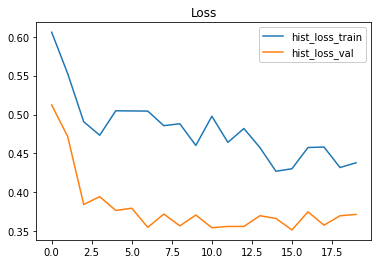

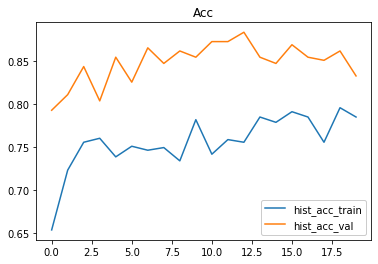

--- 301.1616954803467 seconds ---


In [ ]:
import time
start_time = time.time()
model_ht = train_model(model_ht, criterion_ht, optimizer_ht, exp_lr_scheduler_ht,dataloaders2,dataset_sizes2,
                       num_epochs=EPOCHS)
print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
model_wt = new_model_2stage(model,NAME3)
model_wt = model_wt.to(device)
criterion_wt = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_wt = optim.SGD(model_wt.parameters(), lr=0.001, momentum=0.9)
# optimizer_wt = optim.Adam(model_wt.parameters(), lr=0.0005)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler_wt = lr_scheduler.StepLR(optimizer_wt, step_size=7, gamma=0.1)

Epoch 0/19
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.5003 Acc: 0.7372
val Loss: 0.3032 Acc: 0.9517

Epoch 1/19
----------
train Loss: 0.4298 Acc: 0.7906
val Loss: 0.2768 Acc: 0.9758

Epoch 2/19
----------
train Loss: 0.3990 Acc: 0.7967
val Loss: 0.2279 Acc: 0.9758

Epoch 3/19
----------
train Loss: 0.3778 Acc: 0.8090
val Loss: 0.2047 Acc: 0.9662

Epoch 4/19
----------
train Loss: 0.4161 Acc: 0.7906
val Loss: 0.2403 Acc: 0.9565

Epoch 5/19
----------
train Loss: 0.4115 Acc: 0.7680
val Loss: 0.2013 Acc: 0.9614

Epoch 6/19
----------
train Loss: 0.4169 Acc: 0.7823
val Loss: 0.2121 Acc: 0.9614

Epoch 7/19
----------
train Loss: 0.3980 Acc: 0.7926
val Loss: 0.1857 Acc: 0.9758

Epoch 8/19
----------
train Loss: 0.4070 Acc: 0.7762
val Loss: 0.1756 Acc: 0.9807

Epoch 9/19
----------
train Loss: 0.4054 Acc: 0.7700
val Loss: 0.1634 Acc: 0.9758

Epoch 10/19
----------
train Loss: 0.4025 Acc: 0.7967
val Loss: 0.1890 Acc: 0.9758

Epoch 11/19
----------
train Loss: 0.3855 Acc: 0.7926
val Loss: 0.1741 Acc: 0.9758

Epoch 12/19
----------
t

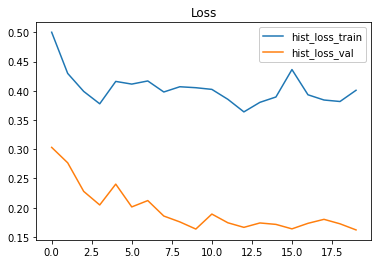

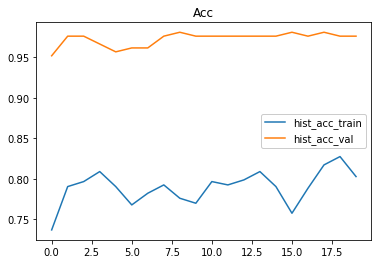

--- 126.0937271118164 seconds ---


In [ ]:
import time
start_time = time.time()
model_wt = train_model(model_wt, criterion_wt, optimizer_wt, exp_lr_scheduler_wt,dataloaders3,dataset_sizes3,
                       num_epochs=EPOCHS)
print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
model_ft.save()

Fires


In [ ]:
model_ht.save()

Humans


In [ ]:
model_wt.save()

Weapons


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Время инфренса батча(мс): 15.119791


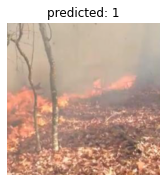

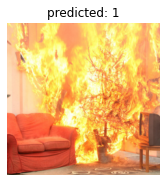

In [ ]:
visualize_model(model_ft.to(device),dataloaders1,class_names1,num_images=2)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Время инфренса батча(мс): 18.885136


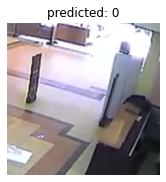

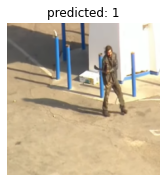

In [ ]:
visualize_model(model_ht.to(device),dataloaders2,class_names2,num_images=2)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Время инфренса батча(мс): 26.272297


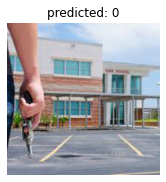

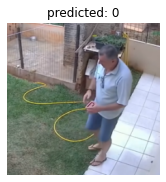

In [ ]:
visualize_model(model_wt.to(device),dataloaders3,class_names3,num_images=2)

In [ ]:
def print_confusion_matrix(model,dataloaders,class_names,color='Oranges'):
    true_labels=[]
    pred_labels=[]
    for inputs, labels in dataloaders['val']:
      pred = model.forward(inputs.to(device))
      _, pred = torch.max(pred, 1)
      labels.to(torch.device("cpu"))
      pred.to(torch.device("cpu"))
      true_labels.extend(labels.tolist());
      pred_labels.extend(pred.tolist());
    cm=metrics.confusion_matrix(true_labels,pred_labels)
    print(cm)
    from pandas import DataFrame
    import seaborn as sn
    df_cm = DataFrame(cm, index=class_names, columns=class_names)
    ax = sn.heatmap(df_cm, cmap=color, annot=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[[18  0]
 [ 4 14]]


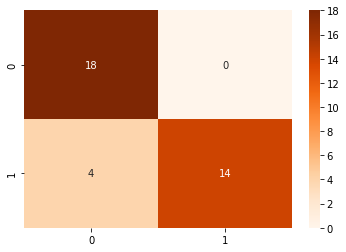

In [ ]:
print_confusion_matrix(model_ft,dataloaders1,class_names1)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[[ 56  50]
 [ 20 146]]


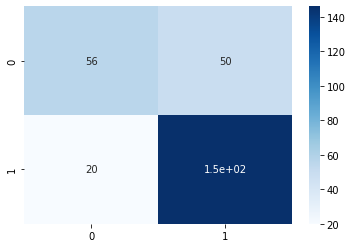

In [ ]:
print_confusion_matrix(model_ht,dataloaders2,class_names2,color='Blues')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[[98  8]
 [37 61]]


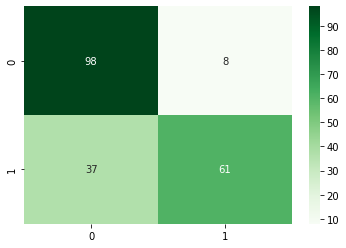

In [ ]:
print_confusion_matrix(model_wt,dataloaders3,class_names3,color='Greens')

In [ ]:
# summary(model_ft, (3, 224, 224))

In [ ]:
!nvidia-smi

Thu Aug 11 18:22:46 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P0    30W /  70W |   1292MiB / 15109MiB |      5%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------